In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install keras-tuner


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner import HyperParameters  # Corrected import statement
from kerastuner.tuners import RandomSearch  # Corrected import statement
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


<ipython-input-3-ee6dba7d7ec6>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters  # Corrected import statement


In [ ]:
df_test = pd.read_csv('../content/drive/MyDrive/Land prices.csv')
df_train = pd.read_csv('../content/drive/MyDrive/Land prices.csv')
df = pd.concat([df_test,df_train])

In [ ]:
df.head()

,No,date,house age,Sq feets,distand to public domin,number of registrations done,latitude,longitude,Y house price of unit area,totsl cost
0,1,2022.06.01,32.0,3214,84.87882,10,24.98298,121.54024,33.0,8.750000e+12
1,2,2022.06.02,19.5,3214,306.59470,9,24.98034,121.53951,42.2,2.220000e+13
2,3,2022.06.03,13.3,3214,561.98450,5,24.98746,121.54391,47.3,1.730000e+13
3,4,2022.06.04,13.3,4957,561.98450,5,24.98746,121.54391,54.8,3.080000e+13
4,5,2022.06.05,5.0,4999,390.56840,5,24.97937,121.54245,43.1,6.390000e+12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 852 entries, 0 to 425
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   No                            852 non-null    int64  
 1   date                          852 non-null    object 
 2    house age                    852 non-null    float64
 3   Sq feets                      852 non-null    int64  
 4   distand to public domin       852 non-null    float64
 5   number of registrations done  852 non-null    int64  
 6   latitude                      852 non-null    float64
 7   longitude                     852 non-null    float64
 8   Y house price of unit area    852 non-null    float64
 9   totsl cost                    852 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 73.2+ KB


In [ ]:
df.describe()

,No,house age,Sq feets,distand to public domin,number of registrations done,latitude,longitude,Y house price of unit area,totsl cost
count,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,8.520000e+02
mean,213.500000,17.673709,5194.854460,1056.084854,4.427230,25.152278,121.716734,38.881925,2.199269e+13
std,123.047501,11.285691,206.709029,1254.121736,3.503983,1.223147,1.223826,14.454053,2.316944e+13
min,1.000000,0.000000,3214.000000,23.382840,0.000000,24.932070,121.473530,7.600000,0.000000e+00
25%,107.000000,9.100000,5101.000000,279.172600,1.000000,24.963050,121.529790,28.100000,3.290000e+12
50%,213.500000,16.050000,5207.500000,491.287950,4.500000,24.971990,121.539130,39.200000,1.645000e+13
75%,320.000000,27.600000,5314.000000,1438.579000,7.000000,24.978860,121.543480,47.300000,3.220000e+13
max,426.000000,43.800000,5420.000000,6488.021000,21.000000,36.974330,133.543100,117.500000,1.270000e+14


In [ ]:
df.columns

Index(['No', 'date', ' house age', 'Sq feets', 'distand to public domin',
       'number of registrations done', 'latitude', 'longitude',
       'Y house price of unit area', 'totsl cost'],
      dtype='object')

In [ ]:
df.shape

(852, 10)

In [ ]:
df.isnull().sum()

No                              0
date                            0
 house age                      0
Sq feets                        0
distand to public domin         0
number of registrations done    0
latitude                        0
longitude                       0
Y house price of unit area      0
totsl cost                      0
dtype: int64

In [ ]:
df.dtypes

No                                int64
date                             object
 house age                      float64
Sq feets                          int64
distand to public domin         float64
number of registrations done      int64
latitude                        float64
longitude                       float64
Y house price of unit area      float64
totsl cost                      float64
dtype: object

In [ ]:
df = df.loc[:,["Y house price of unit area"]].values
train = df[:len(df)-50]
test = df[len(train):]
# reshape
train = train.reshape(train.shape[0],1)

In [ ]:
train.shape

(802, 1)

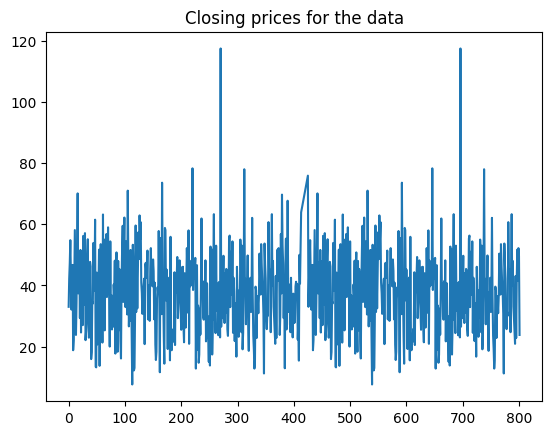

In [ ]:
plt.plot(train);
plt.title("Closing prices for the data");

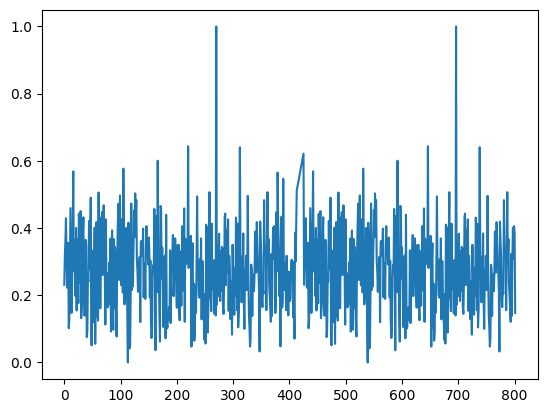

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
train_scaled = scaler.fit_transform(train) # applying to Scaler to train

plt.plot(train_scaled)
plt.show()

In [ ]:
# We add first 50 location to "X_train" and we 51. location to "y_train" .
X_train = []
y_train = []
timesteps = 289

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i-timesteps:i,0])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)


# Reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.

In [ ]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout # it block to overfitting

# Initialising the RCNN
regressor = Sequential()

# Adding the first RCNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second RCNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RCNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RCNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RCNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RCNN to the Training set
regressor.fit(X_train, y_train, epochs = 1, batch_size = 32)

17/17 [==============================] - 6s 151ms/step - loss: 0.4885


In [ ]:
inputs = df[len(df) - len(test) - timesteps:]
inputs = scaler.transform(inputs)

In [ ]:
X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0]) # 0 dan 50 ye, 1 den 51 e gibi kaydirarark 50 eleman aliyoruz
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
predicted_data = regressor.predict(X_test)
predicted_data = scaler.inverse_transform(predicted_data)

2/2 [==============================] - 0s 33ms/step


In [ ]:
predicted_data = regressor.predict(X_test)
predicted_data = scaler.inverse_transform(predicted_data)

2/2 [==============================] - 0s 31ms/step


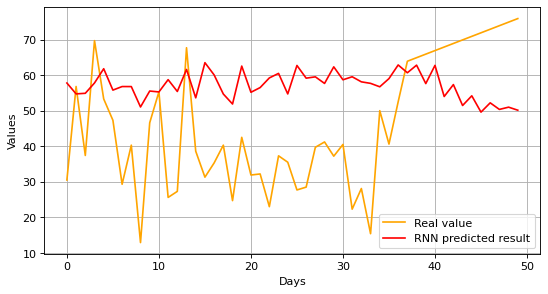

<ipython-input-23-0138f639e10a>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  table_data.append([day, int(real_val), int(pred_val)])  # Convert to integers


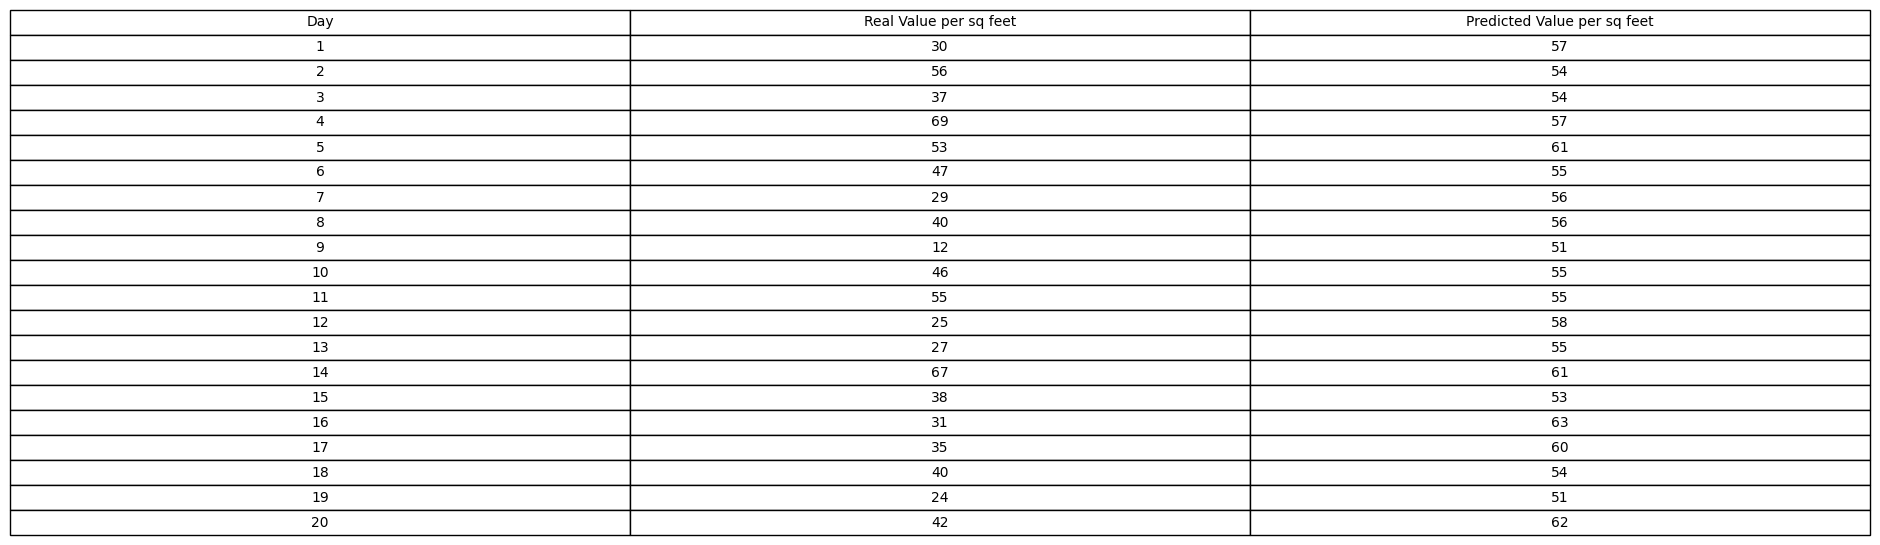

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="orange",label="Real value")
plt.plot(predicted_data,color="r",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

table_data = [['Day', 'Real Value per sq feet', 'Predicted Value per sq feet']]
for day, real_val, pred_val in zip(range(1, 21), test[:20], predicted_data[:20]):
    table_data.append([day, int(real_val), int(pred_val)])  # Convert to integers

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # Turn off axis since we are only showing the table
table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[1, 1, 1])

# Adjust table style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Adjust scaling as needed